In [ ]:
# pip install --quiet scvi-tools

Note: you may need to restart the kernel to use updated packages.


In [19]:
# !pip install scDREAMER
import scDREAMER

In [20]:
import scanpy as sc
import numpy as np
import pandas as pd
import time
import scvi
import anndata
import pandas as pd
from scipy.io import mmread
from scipy.sparse import csr_matrix
import umap
import matplotlib.pyplot as plt
import os
import tempfile
import seaborn as sns
import torch
import scib
import louvain

In [21]:
import warnings

sc.set_figure_params(figsize=(6, 6), frameon=False)
sns.set_theme()
torch.set_float32_matmul_precision("high")
save_dir = tempfile.TemporaryDirectory()

%config InlineBackend.print_figure_kwargs={"facecolor": "w"}
%config InlineBackend.figure_format="retina"

import warnings

# Suppress all warnings
warnings.filterwarnings("ignore")

In [22]:
import os
import scanpy as sc
os.environ["CUDA_VISIBLE_DEVICES"] = "1"
import random
import numpy as np
import tensorflow as tf2
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()

In [23]:
# setting seed for reproducibility
np.random.seed(666)
tf.set_random_seed(666)
random.seed(666)
tf2.random.set_seed(666)
tf2.keras.utils.set_random_seed(666)

In [24]:
import anndata
adata = anndata.read_h5ad("../lung_atlas_public.h5ad")
adata

AnnData object with n_obs × n_vars = 32472 × 15148
    obs: 'dataset', 'location', 'nGene', 'nUMI', 'patientGroup', 'percent.mito', 'protocol', 'sanger_type', 'size_factors', 'sampling_method', 'batch', 'cell_type', 'donor'
    layers: 'counts'

In [7]:
## Setting: randomly missing labels
np.random.seed(666)
total_cells = adata.n_obs

# Calculate the number of cells to label
num_labeled = int(0.5 * total_cells)

# Initialize all labels with NaN
semi_labels = pd.Series(np.nan, index=adata.obs.index)

# Randomly select 50% of the indices without replacement
indices = np.random.choice(adata.obs.index, size=num_labeled, replace=False)

# Assign the corresponding 'cell_type' labels to these selected indices
semi_labels.loc[indices] = adata.obs.loc[indices, 'cell_type']

# Now 'semi_labels' contains 50% known labels and 50% NaN
adata.obs['celltype'] = semi_labels
#when the method requires fillna, ssSTACAS do not need this filling, but scANVI requires)
adata.obs['celltype'].fillna("NA", inplace=True)
adata.obs['celltype'] = adata.obs['celltype'].astype('category')

In [8]:
# Write `adata.obs` to a CSV file named 'metadata.csv'
adata.obs.to_csv('./labels_for_new_methods/randomly_missing_label_lung_atlas_50_obs.tsv')

In [9]:
adata

AnnData object with n_obs × n_vars = 32472 × 15148
    obs: 'dataset', 'location', 'nGene', 'nUMI', 'patientGroup', 'percent.mito', 'protocol', 'sanger_type', 'size_factors', 'sampling_method', 'batch', 'cell_type', 'donor', 'celltype'
    layers: 'counts'

In [10]:
adata.write('./labels_for_new_methods/lung_atlas_randomly_missing_50.h5ad')

In [25]:
embeddings_dict = {}

## scDREAMER
scDREAMER takes h5ad file directly as input.


Leaning rate to use for small data vs large input data: 
learning_rate = {
    "Immune_Human": {"lr_ae": 0.0002, "lr_dis": 0.0007},  # Small Datasets
    "Human_Mouse": {"lr_ae": 0.0001, "lr_dis": 0.00001},
}  # Big Datasets >= 0.5 million cells

it does the data preprocessing by its own function: 
	•	read_h5ad: This function reads the data from an .h5ad file using Scanpy and performs several preprocessing steps:
	•	Normalization: Total counts per cell are normalized to 10,000.
	•	Log Transformation: A log transformation is applied to the data.
	•	Highly Variable Genes: The top 2,000 highly variable genes are selected based on the Seurat method, using the batch key for batch correction.
	•	Data Preparation: The data is then converted into a dense or sparse matrix, depending on sparseIP.
	•	One-Hot Encoding: Batch information and cell type labels are one-hot encoded, which will be used later in the model.
	•	load_gene_mtx: This function loads the dataset, processes it using read_h5ad, and prepares it for input into the model. It handles transformations, normalization, and returns the processed data along with labels and batch information.

Loading dataset
Preprocessing...


OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


here [11 17 11 ... 11 11 10]
Shape self.data_train: (32472, 2000)
Shape self.data_test: (32472, 2000)
encoder input shape  Tensor("concat:0", shape=(?, 2016), dtype=float32)
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
Use `tf.cast` instead.
decoder input shape  Tensor("concat_2:0", shape=(?, 26), dtype=float32)
KL gaussian z Tensor("mul_12:0", shape=(?,), dtype=float32)
KL gaussian l Tensor("mul_11:0", shape=(?,), dtype=float32)
Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See `tf.nn.softmax_cross_entropy_with_logits_v2`.

scDREAMER-Sup on DataSet ./labels_for_new_methods/lung_atlas_randomly_missing_50.h5ad ... 
Epoch : [0] ,  a_loss = 475.6305
Epoch : [10] ,  a_loss = 397.1916
Epoch : [20] ,  a_loss = 381.6386
Epoch : [30] ,  a_loss = 372.1006
Epoch : [40] ,  a_loss = 365.2063
Epoch : [50] ,  a_

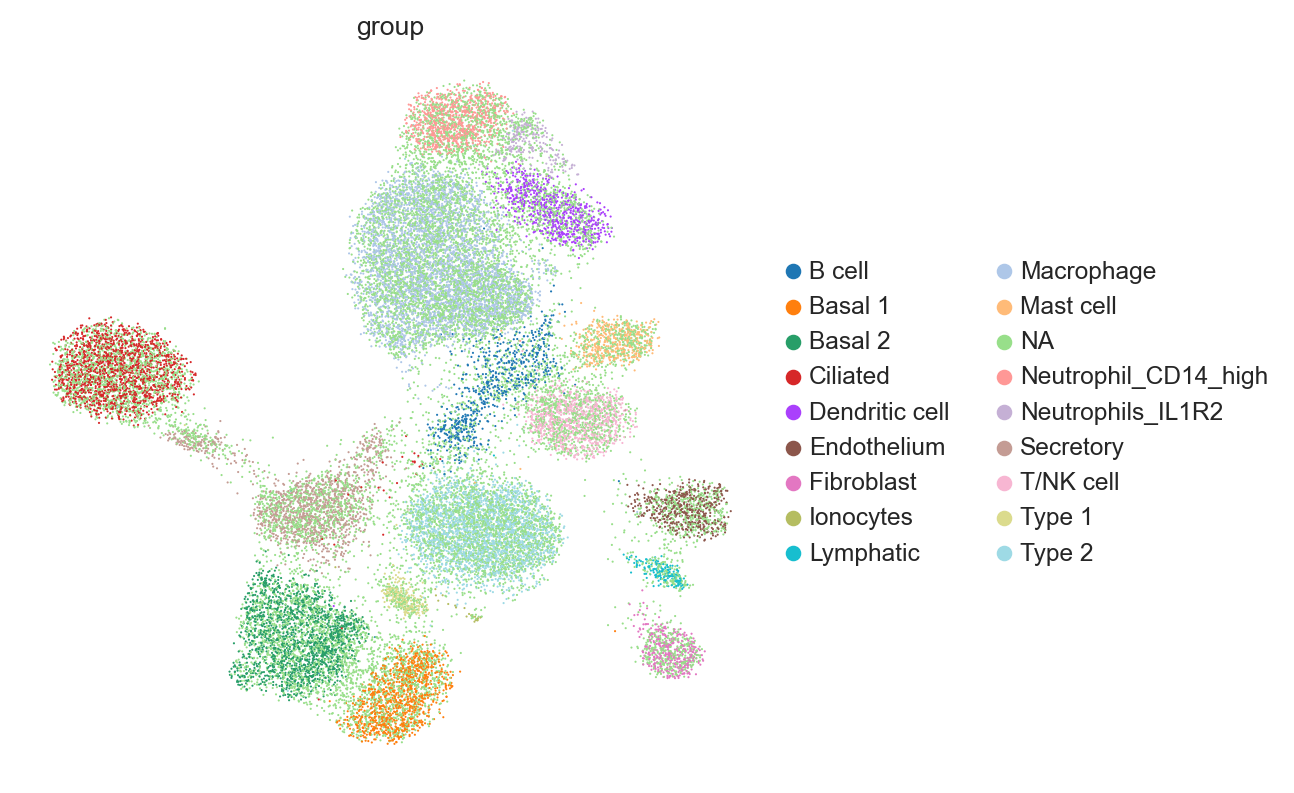

None


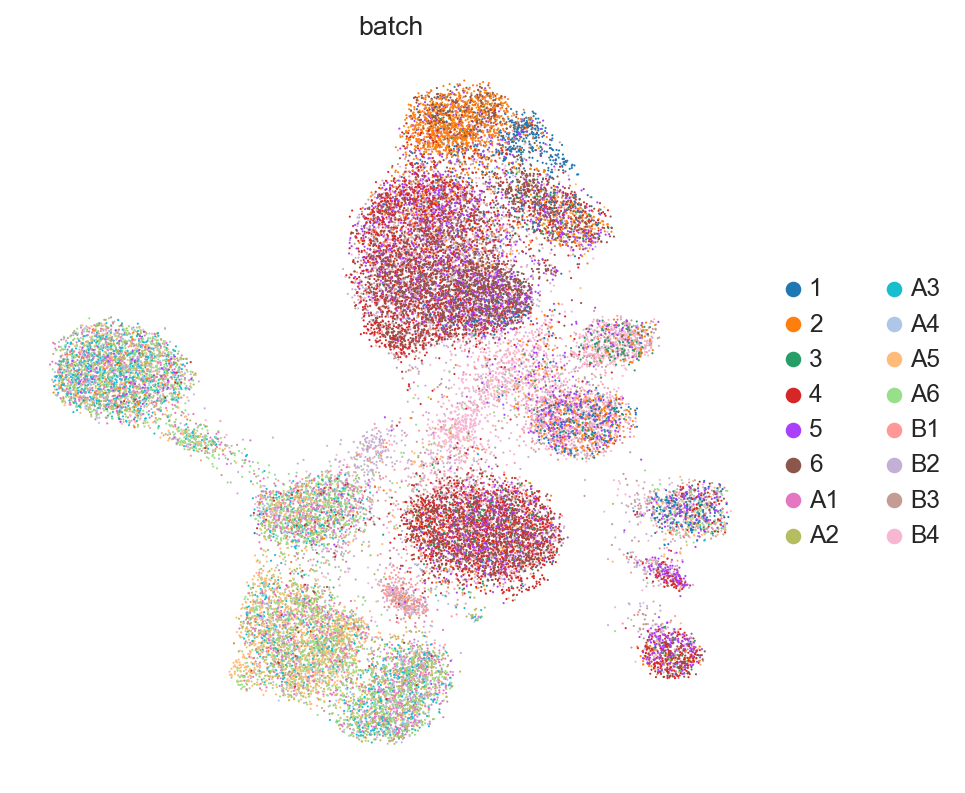

None


In [17]:
import tensorflow as tf
from scDREAMER import scDREAMER_SUP

# Define the single dataset and relevant parameters
name = "Lung_atlas"
dataset_path = "./labels_for_new_methods/lung_atlas_randomly_missing_50.h5ad"

# Define batch and cell type keys
batch_key = 'batch'
cell_type_key = 'celltype'

# Learning rate configuration
lr = {"lr_ae": 0.0002, "lr_dis": 0.0007}

# TensorFlow session configuration
tf.compat.v1.disable_eager_execution()  # Disable eager execution to mimic TensorFlow 1.x behavior
run_config = tf.compat.v1.ConfigProto()
run_config.gpu_options.per_process_gpu_memory_fraction = 0.333
run_config.gpu_options.allow_growth = True

# Run scDREAMER
with tf.compat.v1.Session(config=run_config) as sess:
    dreamer = scDREAMER_SUP(
        sess,
        epoch=240,
        dataset_name=dataset_path,
        batch=batch_key,
        cell_type=cell_type_key,
        plot_cell_type=cell_type_key,
        name=name,
        lr_ae=lr['lr_ae'],
        lr_dis=lr['lr_dis']
    )

    dreamer.train_cluster()

In [31]:
import pandas as pd
pca_embeddings = pd.read_csv('../embeddings/new_methods_embeddings/randomly_missing_label_scdreamer_embeddings_lung_atlas_50.csv', index_col=0)
adata.obsm['X_scDREAMER'] = pca_embeddings.values
sc.pp.neighbors(adata, use_rep="X_scDREAMER")
sc.tl.umap(adata, min_dist=0.5)

In [32]:
# Collect embeddings
embeddings_dict["X_scDREAMER"] = adata.obsm['X_scDREAMER']

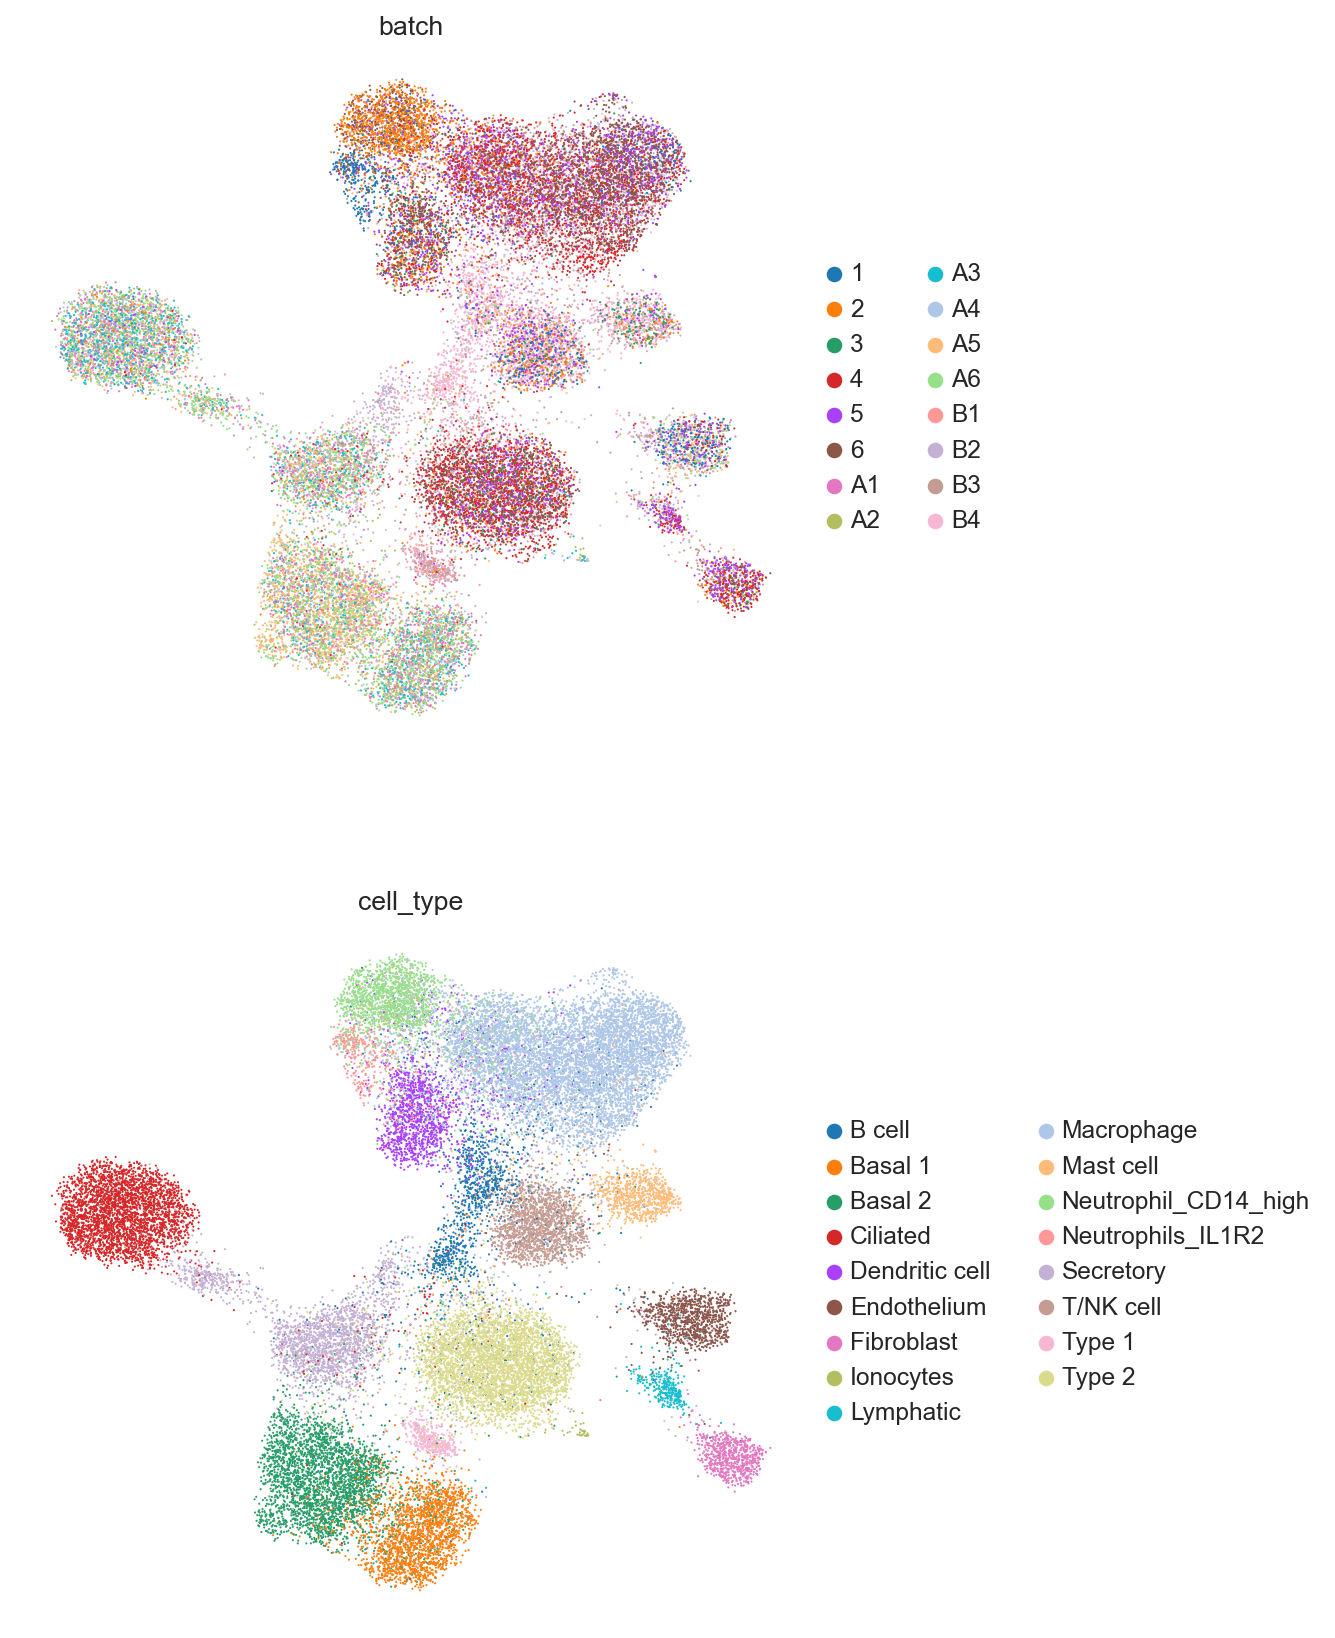

In [33]:
sc.pl.umap(adata, color=["batch", "cell_type"], frameon=False, ncols=1)

# ItClust

In [37]:
pca_embeddings = pd.read_csv('../embeddings/new_methods_embeddings/randomly_missing_label_lung_atlas_itclust_embeddings_50.csv', index_col=0)
adata.obsm['X_ItClust'] = pca_embeddings.values
sc.pp.neighbors(adata, use_rep="X_ItClust")
sc.tl.umap(adata, min_dist=0.5)

In [38]:
# Collect embeddings
embeddings_dict["X_ItClust"] = adata.obsm['X_ItClust']

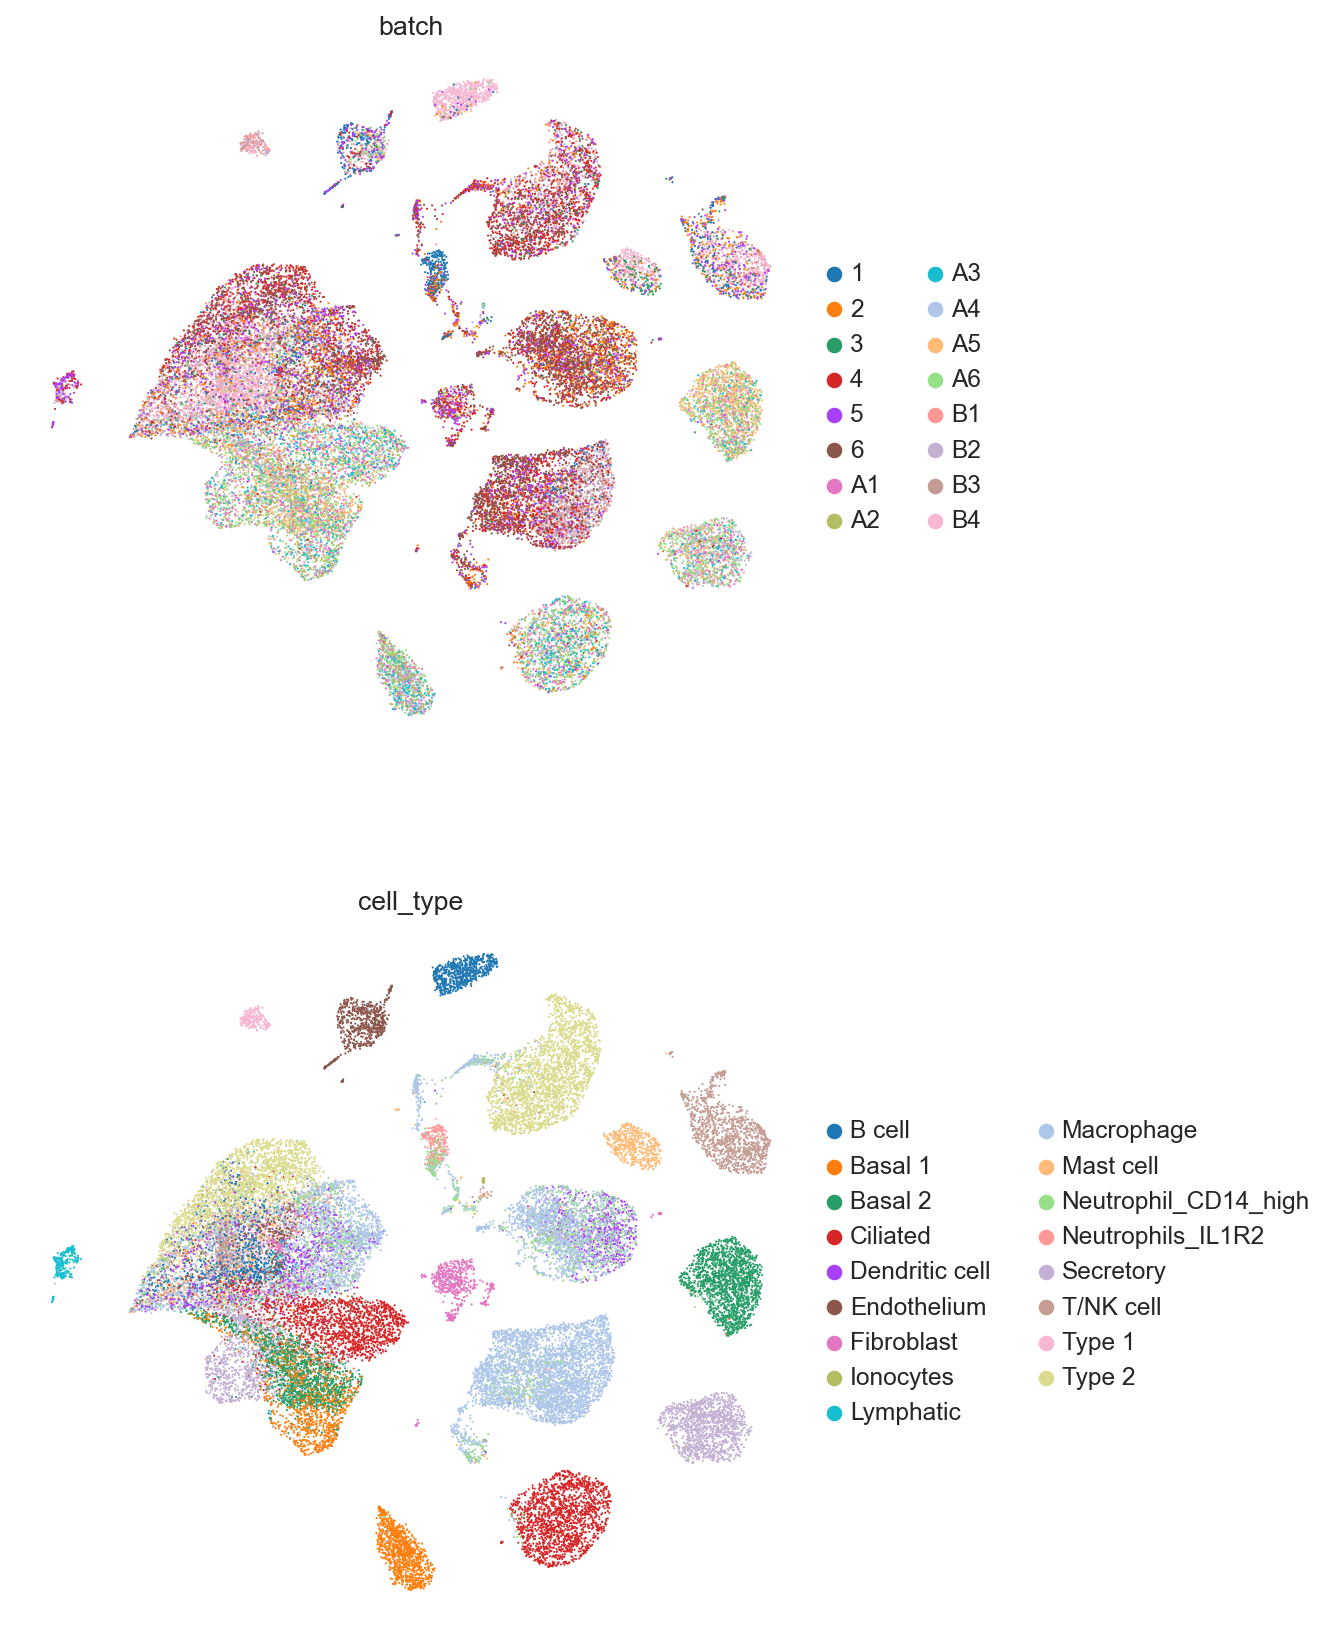

In [39]:
sc.pl.umap(adata, color=["batch", "cell_type"], frameon=False, ncols=1)

In [40]:
# Concatenate embeddings and save to CSV
combined_embeddings = pd.concat(
    {key: pd.DataFrame(value, index=adata.obs_names) for key, value in embeddings_dict.items()},
    axis=1
)
combined_embeddings.to_csv("../embeddings/randomly_missing_label_lung_atlas_new_50.csv")
